In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

#from tensorflow import keras
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import Model

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score, classification_report

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

import glob
import os

C:\Users\Asya\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Asya\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Read the CSV data to get nested dictionary of structure data->label->kind, where labels are types of the cell medium (description is in the README) and kind is chemical modification of the nanoparticles, used to collect spectra (one of the NH2, COOH, (COOH)2). We will normalize the data to the (0,1) range, so define normalizing function in advance.

# Meet the data

In [2]:
def norm_func(x, a=0, b=1):
    return ((b - a) * (x - min(x))) / (max(x) - min(x)) + a

def normalize(x, y=None):
    x = np.apply_along_axis(norm_func, axis=1, arr=x)
    return x

data={}
data_count={}
#for file in glob.glob("../input/cells-raman-spectra/dataset_i/**/*.csv"):
for file in glob.glob("C:/Users/Asya/Desktop/Chemometrics/Training - cell Raman spectra/data/dataset_i/**/*.csv"):    
    path = file.split(os.path.sep)
    label = path[-2]
    kind = path[-1][:-4]
    if label not in data.keys():
        data[label] = {}
        data_count[label] = {}
    data[label][kind] = normalize(pd.read_csv(file).values)
    data_count[label][kind] = len(data[label][kind])

In [3]:
#Calculate how much spectra in total
data_count_df = pd.DataFrame(data_count)
data_count_df = data_count_df.T
data_count_df['Total'] = data_count_df[['(COOH)2','COOH','NH2']].sum(axis=1)
display(data_count_df)
data_count_df.sum()

(COOH)2  COOH  NH2  Total
A            53    53   59    165
A-S          51    56   50    157
DMEM         64    64   65    193
DMEM-S       53    52   53    158
G            52    54   51    157
G-S          50    51   50    151
HF           56    50   51    157
HF-S         50    51   50    151
MEL          49    50   50    149
MEL-S        50    52   51    153
ZAM          50    50   50    150
ZAM-S        49    50   52    151

(COOH)2     627
COOH        633
NH2         632
Total      1892
dtype: int64

##### We will compare just fibroblasts - healthy and cancer ones, as they both were derived from patients.

In [4]:
celltypes_used = ['HF','ZAM']

Check the data read by observing keys and plotting couple of spectra.

In [5]:
wv = np.linspace(100, 4178, 2090) #names of our features

In [6]:
def subplot_visualizer (sub_ax, color, wv, celltype, aunp_type, means, stds=None, logscale=False, plot_type='line'):
    """visualize in a given subplot a given spectral family with +- std cloud"""
    
    if plot_type == 'line':
        sub_ax.plot(wv, means[celltype][aunp_type], color=color)

        if stds is not None: #draw a 'cloud' of +-stds
            sub_ax.fill_between(wv, 
                     means[celltype][aunp_type] - stds[celltype][aunp_type], means[celltype][aunp_type] + stds[celltype][aunp_type],
                    color=color, alpha=0.2)
    elif plot_type == 'bar':
        sub_ax.bar(wv, means[celltype][aunp_type], color=color)
        
    if logscale:
        sub_ax.set_yscale('log')
        sub_ax.set_ylim([0.001,1])


In [7]:
mean_data = {key:{} for key in celltypes_used}
std_data = {key:{} for key in celltypes_used}

for key in celltypes_used:
    for kind in data[key]:
        mean_data[key][kind] = data[key][kind].mean(axis=0)
        std_data[key][kind] = data[key][kind].std(axis=0)
        

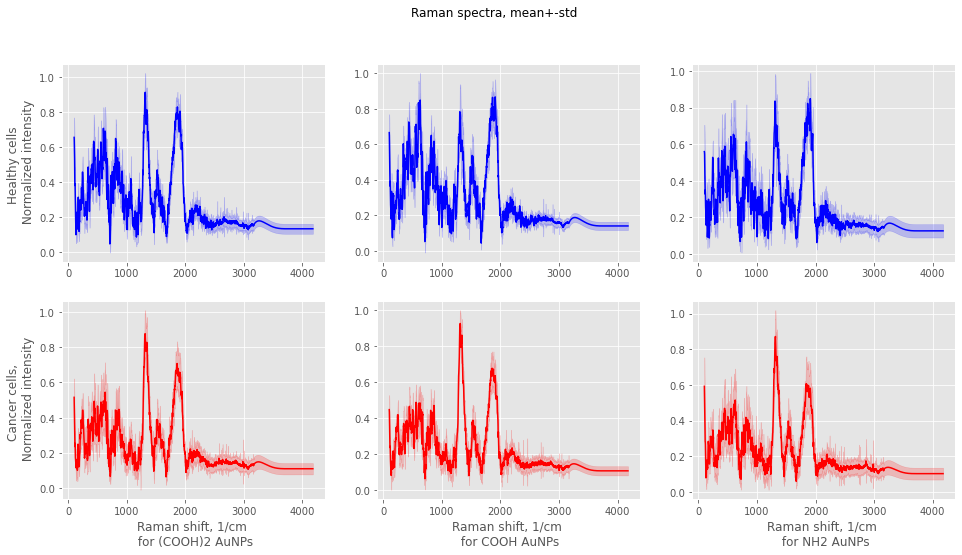

In [8]:
fig,ax = plt.subplots(2,3, figsize=(16,8))
subplot_visualizer (sub_ax=ax[0,0], color='b', wv=wv, means=mean_data, stds=std_data, celltype='HF', aunp_type='(COOH)2')
subplot_visualizer (sub_ax=ax[0,1], color='b', wv=wv, means=mean_data, stds=std_data, celltype='HF', aunp_type='COOH')
subplot_visualizer (sub_ax=ax[0,2], color='b', wv=wv, means=mean_data, stds=std_data, celltype='HF', aunp_type='NH2')

subplot_visualizer (sub_ax=ax[1,0], color='r', wv=wv, means=mean_data, stds=std_data, celltype='ZAM', aunp_type='(COOH)2')
subplot_visualizer (sub_ax=ax[1,1], color='r', wv=wv, means=mean_data, stds=std_data, celltype='ZAM', aunp_type='COOH')
subplot_visualizer (sub_ax=ax[1,2], color='r', wv=wv, means=mean_data, stds=std_data, celltype='ZAM', aunp_type='NH2')
plt.setp(ax[-1, 0], xlabel='Raman shift, 1/cm \n for (COOH)2 AuNPs')
plt.setp(ax[-1, 1], xlabel='Raman shift, 1/cm \n for COOH AuNPs')
plt.setp(ax[-1, 2], xlabel='Raman shift, 1/cm \n for NH2 AuNPs')

plt.setp(ax[0, 0], ylabel='Healthy cells \n Normalized intensity')
plt.setp(ax[1, 0], ylabel='Cancer cells, \n Normalized intensity')
fig.suptitle('Raman spectra, mean+-std');

# EDA

## Statistical testing
### Firstly, Check if data is normally distributed

In [9]:
from scipy.stats import  normaltest # D'Agostino test
from collections import defaultdict

normaltest_p_list = {key:{} for key in celltypes_used}


for key in celltypes_used:
    for kind in data[key]:         
        for feature_row in np.arange(len(wv)):
            _, p = normaltest(data[key][kind][:, feature_row])
            if kind not in normaltest_p_list[key].keys():
                    normaltest_p_list[key][kind] = []
            normaltest_p_list[key][kind].append(p)

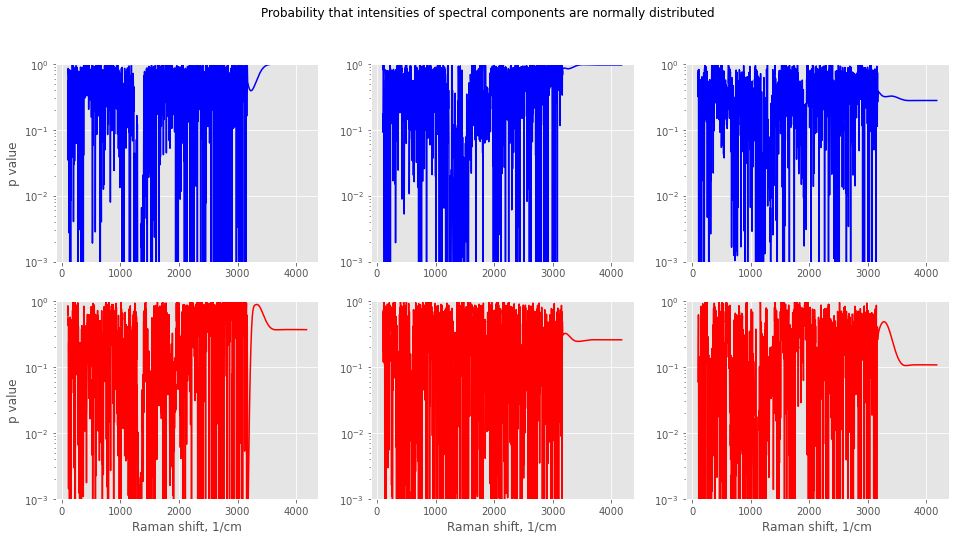

In [10]:
fig,ax = plt.subplots(2,3, figsize=(16,8))
subplot_visualizer (sub_ax=ax[0,0], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='(COOH)2', logscale=True)
subplot_visualizer (sub_ax=ax[0,1], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='COOH', logscale=True)
subplot_visualizer (sub_ax=ax[0,2], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='NH2', logscale=True)

subplot_visualizer (sub_ax=ax[1,0], color='r', wv=wv, means=normaltest_p_list,  celltype='ZAM', aunp_type='(COOH)2', logscale=True)
subplot_visualizer (sub_ax=ax[1,1], color='r', wv=wv, means=normaltest_p_list,   celltype='ZAM', aunp_type='COOH', logscale=True)
subplot_visualizer (sub_ax=ax[1,2], color='r', wv=wv, means=normaltest_p_list,   celltype='ZAM', aunp_type='NH2', logscale=True)
plt.setp(ax[-1, :], xlabel='Raman shift, 1/cm')
plt.setp(ax[:, 0], ylabel='p value')
fig.suptitle('Probability that intensities of spectral components are normally distributed');

###### Sub-conclusion: p-values are controversary. Ok, really it's not applicable to compare all features

### Savitzky-Golay filter

In [11]:
from scipy.signal import savgol_filter

data_filt = {key:{} for key in celltypes_used}

for key in celltypes_used:
    for kind in data[key]:  
        data_filt[key][kind] = savgol_filter(data[key][kind], window_length=29, polyorder=12)

In [12]:
mean_filt = {key:{} for key in data_filt.keys()}
std_filt = {key:{} for key in data_filt.keys()}

for key in data_filt:
    for kind in data_filt[key]:
        mean_filt[key][kind] = data_filt[key][kind].mean(axis=0)
        std_filt[key][kind] = data_filt[key][kind].std(axis=0)

In [13]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(x=wv, y=mean_filt['HF']['NH2'])
#fig = px.line(x=wv, y=mean_filt['HF']['NH2'])
fig.update_traces(name='Filtered', showlegend = True)
fig.add_trace(go.Scatter(x=wv, y=mean_data['HF']['NH2'], mode='lines', name='Raw', showlegend=True))
fig.update_layout(title='Comparizon of savgol-filtered and raw mean HF cells with NH2-modified AuNPs', 
                  xaxis_title='Raman shift, 1/cm', 
                  yaxis_title='Intensity')
fig.show()

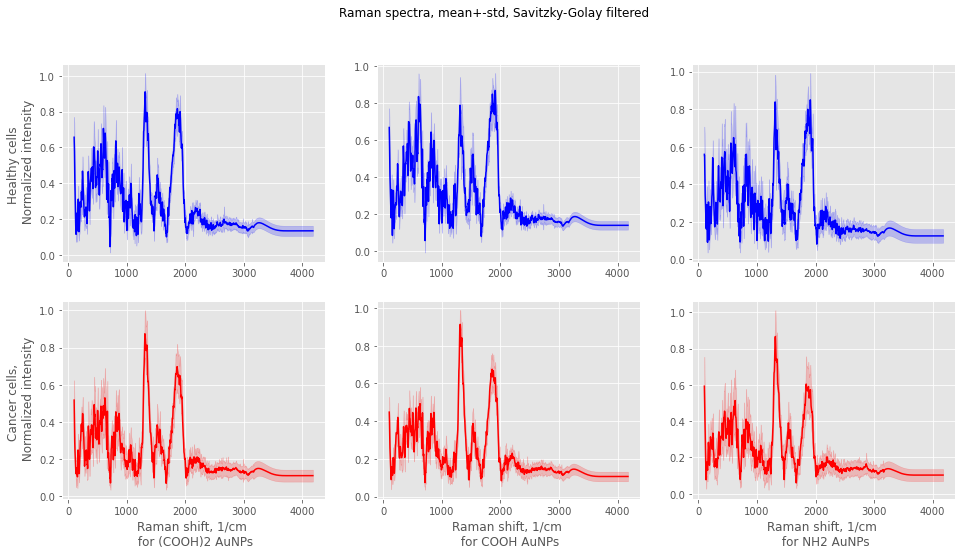

In [14]:
fig,ax = plt.subplots(2,3, figsize=(16,8))
subplot_visualizer (sub_ax=ax[0,0], color='b', wv=wv, means=mean_filt, stds=std_filt, celltype='HF', aunp_type='(COOH)2')
subplot_visualizer (sub_ax=ax[0,1], color='b', wv=wv, means=mean_filt, stds=std_filt, celltype='HF', aunp_type='COOH')
subplot_visualizer (sub_ax=ax[0,2], color='b', wv=wv, means=mean_filt, stds=std_filt, celltype='HF', aunp_type='NH2')

subplot_visualizer (sub_ax=ax[1,0], color='r', wv=wv, means=mean_filt, stds=std_filt, celltype='ZAM', aunp_type='(COOH)2')
subplot_visualizer (sub_ax=ax[1,1], color='r', wv=wv, means=mean_filt, stds=std_filt, celltype='ZAM', aunp_type='COOH')
subplot_visualizer (sub_ax=ax[1,2], color='r', wv=wv, means=mean_filt, stds=std_filt, celltype='ZAM', aunp_type='NH2')
plt.setp(ax[-1, 0], xlabel='Raman shift, 1/cm \n for (COOH)2 AuNPs')
plt.setp(ax[-1, 1], xlabel='Raman shift, 1/cm \n for COOH AuNPs')
plt.setp(ax[-1, 2], xlabel='Raman shift, 1/cm \n for NH2 AuNPs')

plt.setp(ax[0, 0], ylabel='Healthy cells \n Normalized intensity')
plt.setp(ax[1, 0], ylabel='Cancer cells, \n Normalized intensity')
fig.suptitle('Raman spectra, mean+-std, Savitzky-Golay filtered');

### Data test for normality for savgol-filtered data

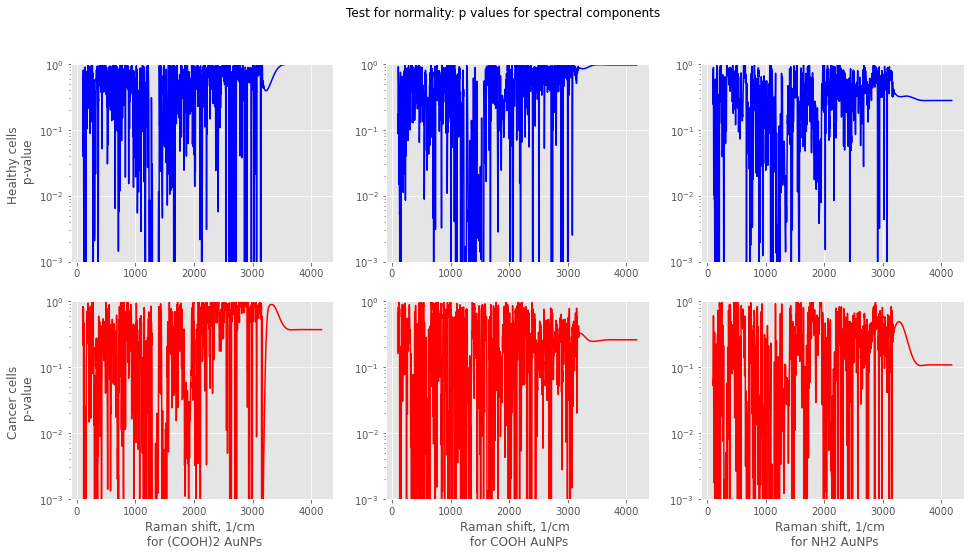

In [15]:
from scipy.stats import  normaltest # D'Agostino test
from collections import defaultdict

normaltest_p_list = {key:{} for key in data_filt.keys()}


for key in data_filt:
    for kind in data_filt[key]:         
        for feature_row in np.arange(len(wv)):
            _, p = normaltest(data_filt[key][kind][:, feature_row])
            if kind not in normaltest_p_list[key].keys():
                    normaltest_p_list[key][kind] = []
            normaltest_p_list[key][kind].append(p)

fig,ax = plt.subplots(2,3, figsize=(16,8))
subplot_visualizer (sub_ax=ax[0,0], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='(COOH)2', logscale=True)
subplot_visualizer (sub_ax=ax[0,1], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='COOH', logscale=True)
subplot_visualizer (sub_ax=ax[0,2], color='b', wv=wv, means=normaltest_p_list,   celltype='HF', aunp_type='NH2', logscale=True)

subplot_visualizer (sub_ax=ax[1,0], color='r', wv=wv, means=normaltest_p_list,  celltype='ZAM', aunp_type='(COOH)2', logscale=True)
subplot_visualizer (sub_ax=ax[1,1], color='r', wv=wv, means=normaltest_p_list,   celltype='ZAM', aunp_type='COOH', logscale=True)
subplot_visualizer (sub_ax=ax[1,2], color='r', wv=wv, means=normaltest_p_list,   celltype='ZAM', aunp_type='NH2', logscale=True)
plt.setp(ax[-1, 0], xlabel='Raman shift, 1/cm \n for (COOH)2 AuNPs')
plt.setp(ax[-1, 1], xlabel='Raman shift, 1/cm \n for COOH AuNPs')
plt.setp(ax[-1, 2], xlabel='Raman shift, 1/cm \n for NH2 AuNPs')
plt.setp(ax[0, 0], ylabel='Healthy cells \n p-value')
plt.setp(ax[1, 0], ylabel='Cancer cells \n p-value')

fig.suptitle('Test for normality: p values for spectral components');

###### Sub-conclusion: after savgol filtering, p-values are controversary. Ok, really it's not applicable to compare all features, let's proceed to just features of interest

### Working with peaks (features) of interest

In [16]:
delta={}
for kind in data_filt[key]:
        delta[kind] = mean_filt['HF'][kind] - mean_filt['ZAM'][kind]


In [17]:
delta_df=pd.DataFrame(data=delta, index=np.round(wv,1))

In [18]:
fig = px.line(delta_df)
fig.update_layout(title='Delta for healthy-cancer filtered means', 
                  xaxis_title='Raman shift, 1/cm', 
                  yaxis_title='Intensity')

599.7     0.369715
597.8     0.360984
601.7     0.349908
433.8     0.341728
631.0     0.341073
            ...   
105.9     0.202941
449.4     0.202702
591.9     0.202413
1864.7    0.202083
1905.7    0.200562
Name: COOH, Length: 106, dtype: float64

Text(0, 0.5, 'counts')

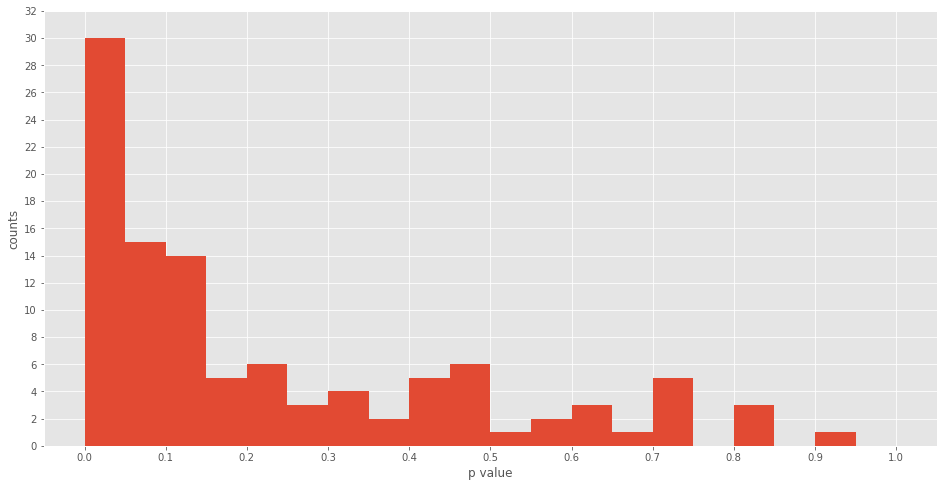

In [19]:
#for COOH, find top deltas
delta_sorted_COOH = abs(delta_df['COOH']).sort_values(ascending=False) #sort all deltas
delta_top_COOH = delta_sorted_COOH[delta_sorted_COOH > 0.2] #cut top
display(delta_top_COOH)

#for them, perform normaltest
normaltest_p_toplist = {key:{} for key in data_filt.keys()}
for top_wv in delta_top_COOH.index: #at which wavenumber
    top_idx = delta_df.index.get_loc(top_wv) #which index it is in base data
    for key in ['HF','ZAM']:
            kind='COOH'
            _, p = normaltest(data_filt[key][kind][:, top_idx])
            if kind not in normaltest_p_toplist[key].keys():
                    normaltest_p_toplist[key][kind] = []
            normaltest_p_toplist[key][kind].append(p)

#visualize
fig,ax = plt.subplots(figsize=(16,8))
#subplot_visualizer (sub_ax=ax[0,1], color='b', 
#                    wv=delta_top_COOH.index, means=normaltest_p_toplist,   
#                    celltype='HF', aunp_type='COOH', logscale=False, plot_type='bar')
plt.hist(normaltest_p_toplist['HF']['COOH'], bins=20, range=[0,1]);
ax.set_xticks (np.arange(start=0,stop=1.05,step=0.1))
ax.set_yticks (np.arange(start=0,stop=34,step=2));
plt.xlabel('p value')
plt.ylabel('counts')

##### Still, one third of peaks is distributed normally (p < 0.05) and others aren't.

## Dividing to train_val and test
##### for savgol-filtered data

In [20]:
def transform_to_XY(data_1celltype,ylabel, aunp_kind='all'):
    """Transforms a dictionary with keys AuNP types to X array, where each row is a set of 3 spectras"""
    if aunp_kind=='all':
        n_samples = min(len(data_1celltype['(COOH)2']), len(data_1celltype['COOH']), len(data_1celltype['NH2']))
        X_list = []
        for i in range (n_samples):
            X_row = np.concatenate([data_1celltype['(COOH)2'][i], data_1celltype['COOH'][i], data_1celltype['NH2'][i]])
            X_list.append(X_row)
    else:
        n_samples = len(data_1celltype[aunp_kind])        
        X_list = data_1celltype[aunp_kind]
    
    print('n_samples: ', n_samples)         
    X = np.array(X_list)
    Y = ylabel*np.ones(n_samples)
    
    return X, Y

In [21]:
X_HF, Y_HF = transform_to_XY(data_1celltype = data_filt['HF'], ylabel = 0)
print('HF dataset, X: ',X_HF.shape)
X_ZAM, Y_ZAM = transform_to_XY(data_1celltype = data_filt['ZAM'], ylabel = 1)
print('ZAM dataset, X: ',X_ZAM.shape)

X = np.concatenate([X_HF, X_ZAM], axis=0)
Y = np.concatenate([Y_HF, Y_ZAM], axis=0)
print('Overall dataset, X: ',X.shape)

n_samples:  50
HF dataset, X:  (50, 6270)
n_samples:  50
ZAM dataset, X:  (50, 6270)
Overall dataset, X:  (100, 6270)


In [22]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=42)
print('X_train_val: ',X_train_val.shape)
print('X_test: ',X_test.shape)

X_train_val:  (80, 6270)
X_test:  (20, 6270)


## Correlation matrix

In [23]:
corr = pd.DataFrame(data=X_train_val).corr(method='spearman')
display(corr)

0         1         2         3         4         5         6     \
0     1.000000  0.884552  0.869667  0.883732  0.867745  0.857595  0.853446   
1     0.884552  1.000000  0.939053  0.909587  0.891913  0.878950  0.880520   
2     0.869667  0.939053  1.000000  0.973957  0.914955  0.867745  0.876981   
3     0.883732  0.909587  0.973957  1.000000  0.968448  0.918354  0.898570   
4     0.867745  0.891913  0.914955  0.968448  1.000000  0.977614  0.938186   
...        ...       ...       ...       ...       ...       ...       ...   
6265  0.126770  0.202883  0.152274  0.154805  0.174519  0.200680  0.187670   
6266  0.126770  0.202883  0.152274  0.154805  0.174519  0.200680  0.187670   
6267  0.126770  0.202883  0.152274  0.154805  0.174519  0.200680  0.187670   
6268  0.126770  0.202883  0.152274  0.154805  0.174519  0.200680  0.187670   
6269  0.126770  0.202883  0.152274  0.154805  0.174519  0.200680  0.187670   

          7         8         9     ...      6260      6261      6262  \
0     0.813854  0.762986  0.686967  ...  0.126770  0.126770  0.126770   
1     0.841514  0.794796  0.736263  ...  0.202883  0.202883  0.202883   
2     0.873301  0.853024  0.802649  ...  0.152274  0.152274  0.152274   
3     0.867112  0.835654  0.793038  ...  0.154805  0.154805  0.154805   
4     0.866831  0.797023  0.733263  ...  0.174519  0.174519  0.174519   
...        ...       ...       ...  ...       ...       ...       ...   
6265  0.138983  0.074332  0.030895  ...  1.000000  1.000000  1.000000   
6266  0.138983  0.074332  0.030895  ...  1.000000  1.000000  1.000000   
6267  0.138983  0.074332  0.030895  ...  1.000000  1.000000  1.000000   
6268  0.138983  0.074332  0.030895  ...  1.000000  1.000000  1.000000   
6269  0.138983  0.074332  0.030895  ...  1.000000  1.000000  1.000000   

          6263      6264      6265      6266      6267      6268      6269  
0     0.126770  0.126770  0.126770  0.126770  0.126770  0.126770  0.126770  
1     0.202883  0.202883  0.202883  0.202883  0.202883  0.202883  0.202883  
2     0.152274  0.152274  0.152274  0.152274  0.152274  0.152274  0.152274  
3     0.154805  0.154805  0.154805  0.154805  0.154805  0.154805  0.154805  
4     0.174519  0.174519  0.174519  0.174519  0.174519  0.174519  0.174519  
...        ...       ...       ...       ...       ...       ...       ...  
6265  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
6266  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
6267  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
6268  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
6269  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  

[6270 rows x 6270 columns]

In [24]:
corr.isna().sum().sum()

0

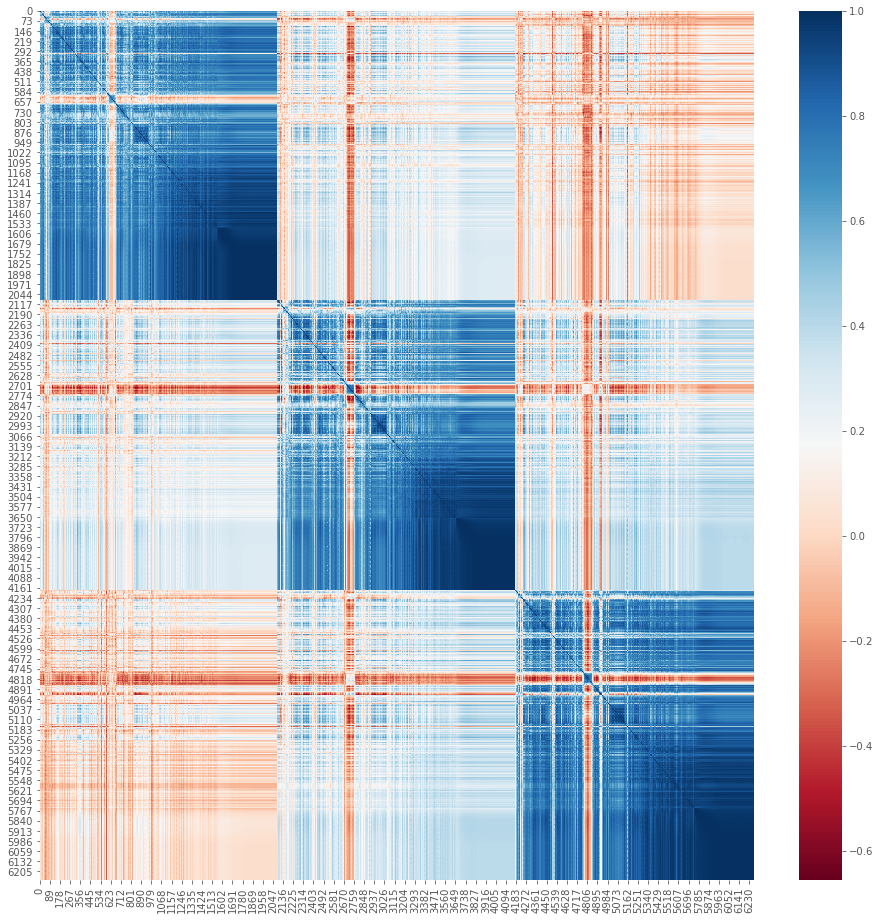

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,16))
img = sns.heatmap(corr, cmap='RdBu')
plt.show()

##### Data in one spectrum are higly correlated with each other (remember that for each sample we have 3 spectra)

# Dimensionality reduction: PCA

#### Data preparation

In [26]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [27]:
#Will norm each spectra by its area
area_norm = X_train_val.sum(axis=1)
spectra_normed_trainval = np.array(X_train_val)/area_norm[:,None]
spectra_normed_trainval.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
#Now scale every feature separately
pre_pca_scaler = preprocessing.StandardScaler()
X_scaled = pre_pca_scaler.fit_transform(spectra_normed_trainval) 

In [29]:
# for using far below, let's process test data in the same way
area_norm = X_test.sum(axis=1)
spectra_normed_test = np.array(X_test)/area_norm[:,None] #Normalized each spectrum by its own weight
Xtest_scaled = pre_pca_scaler.transform(spectra_normed_test) #Then standardized each feature (as previously set)


#### PCA implementation

In [30]:
pca = PCA(n_components=10, random_state=42)

principalComponents_trainval = pca.fit_transform(X_scaled)
principalComponents_test = pca.transform(Xtest_scaled)

principalDataframe_trainval = pd.DataFrame(data = principalComponents_trainval, columns = np.arange(1, 11))

In [31]:
Y_train_val_cat = pd.DataFrame(data=np.round(Y_train_val,0), columns=['class']).astype('category')
principalDataframe_trainval_y = pd.concat([principalDataframe_trainval, Y_train_val_cat], axis=1)
principalDataframe_trainval_y

1          2          3          4          5          6  \
0   72.534036  11.630214  27.890221  10.584352   5.810176  12.025096   
1   15.107602 -25.256309 -17.649742  -1.095782 -13.229371   0.058152   
2  -99.830893  29.403614 -21.187188  -0.095399  27.930814 -10.546703   
3  -32.075720 -34.570115 -11.371872 -14.117318  -1.477976   6.950988   
4  -22.123335 -47.826027 -19.567011  -6.974843  13.111493  -3.646689   
..        ...        ...        ...        ...        ...        ...   
75 -43.140261   6.929985  16.136449  16.062453  -6.894782   2.971704   
76 -50.124637   6.801498  11.471915  13.945635  -9.130883  -2.195586   
77   2.670041  58.758629 -16.211885   0.816183   9.313530  -5.999346   
78 -16.119045  21.110604  18.166037  -1.952297  -7.493617  -8.590131   
79   6.062326  -0.924688  -7.834812  37.754993 -11.277491  -6.814662   

            7          8          9         10 class  
0    4.311227  -8.545255   0.757813  14.018698   0.0  
1   -2.147984  -3.942587  -6.309822  -2.041117   1.0  
2    2.122052  14.222785 -13.780087  14.975769   1.0  
3   14.721223   9.107690  -0.090591 -10.448279   1.0  
4   -8.101749  18.985577  -6.719635  10.706044   1.0  
..        ...        ...        ...        ...   ...  
75  -1.957913   8.409385  -6.464452  -4.392424   0.0  
76  -3.291679   1.940475  -2.256641  -4.923281   0.0  
77  13.881486   1.309992   3.363824 -11.546786   1.0  
78   5.572077 -14.239776  -4.394674  -9.504400   0.0  
79  -6.047164  -4.183993   1.416185   3.942395   0.0  

[80 rows x 11 columns]

In [32]:
import plotly.express as px

fig = px.scatter(principalDataframe_trainval_y, x=1, y=2, color = 'class')
fig.update_traces(marker_size=10)
fig.update_layout(xaxis_title='PC1', yaxis_title='PC2' )
fig.show()

In [33]:
fig = px.scatter( principalDataframe_trainval_y, x=2, y=3, color = 'class')
fig.update_traces(marker_size=10)
fig.update_layout(xaxis_title='PC2', yaxis_title='PC3')
fig.show()

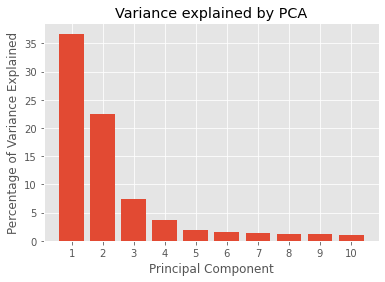

In [34]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = np.arange(1,11)
plt.bar(x= columns, height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Variance explained by PCA')
plt.show()

Text(0.5, 1.0, 'PCA Correlation matrix')

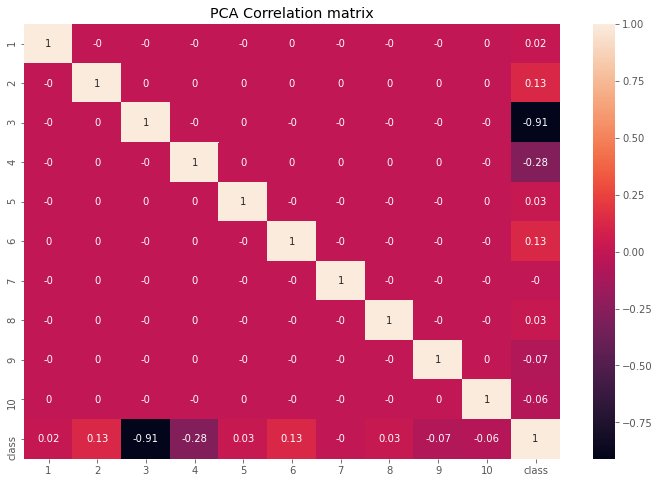

In [35]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(np.round(principalDataframe_trainval_y.corr(numeric_only=False),2), annot=True)
plt.title('PCA Correlation matrix')

##### We can see that PC3 is highly correlated with class label.
##### Meanwhile, PCs are not correlated with each other, that is natural due to their indepencence

# Machine Learning Modeling

##### According to PCA plots, Logistic Regression should divide data well.

## a) Use all 3 spectra types (all 3 types of AuNPs)

## Logistic Regression

In [36]:
X_trainval_PCA = principalDataframe_trainval

scaler = preprocessing.StandardScaler()
X_trainval_PCA_scaled = scaler.fit_transform(X_trainval_PCA) 
Xtest_scaled = scaler.transform(principalComponents_test)


In [37]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='sag')
logreg.fit(X_trainval_PCA_scaled, Y_train_val)

LogisticRegression(solver='sag')

#### Classification report

In [38]:
Y_trainval_predict = logreg.predict(X_trainval_PCA_scaled)
print('Results on a train set:')
print(classification_report(Y_train_val, Y_trainval_predict))

Results on a train set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [39]:
Y_test_predict = logreg.predict(Xtest_scaled)
print('Results on a test set:')
print(classification_report(Y_test, Y_test_predict))

Results on a test set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



#### ROC AUC

ROC AUC on a test set: 1.00


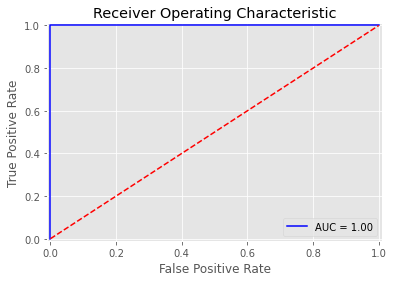

In [40]:
Y_test_pred_proba = logreg.predict_proba(Xtest_scaled)
print('ROC AUC on a test set: {:.2f}'.format(roc_auc_score(Y_test, Y_test_pred_proba[:,1])))

preds = Y_test_pred_proba[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Suspiciously perfect model performance. Therefore, let us use cross validation

## Cross Validation

In [41]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = linear_model.LogisticRegression(solver='sag')

train_recall = []
val_recall = []
train_rocauc = []
val_rocauc = []
    
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, val_index in kf.split(X_train_val, Y_train_val): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, Y_train = X[train_index,:], Y[train_index]
    X_val, Y_val = X[val_index,:], Y[val_index]
    
    #Processing before PCA for train
    ##Normalize each spectrum
    area_norm = X_train.sum(axis=1)
    spectra_normed_train = np.array(X_train)/area_norm[:,None]
    ##Standardize each feature
    pre_pca_scaler = preprocessing.StandardScaler()
    X_scaled_train = pre_pca_scaler.fit_transform(spectra_normed_train)
    
    #Performing PCA on train
    pca = PCA(n_components=10, random_state=42)
    principalComponents_train = pca.fit_transform(X_scaled_train)
    #principalDataframe_train = pd.DataFrame(data = principalComponents_train, columns = np.arange(1, 11))
    #Y_train_cat = pd.DataFrame(data=np.round(Y_train,0), columns=['class']).astype('category')
    #principalDataframe_y = pd.concat([principalDataframe_train, Y_train_cat], axis=1)
    
    #After PCA, preparing train to ML
    scaler = preprocessing.StandardScaler()
    X_train_PCA_scaled = scaler.fit_transform(principalComponents_train) 
    
    #Processing before PCA for val
    area_norm = X_val.sum(axis=1)
    spectra_normed_val = np.array(X_val)/area_norm[:,None] #Normalized each spectrum by its own weight
    X_val_scaled = pre_pca_scaler.transform(spectra_normed_val) #Then standardized each feature (as previously set)

    #Performing PCA on val
    principalComponents_val = pca.transform(X_val_scaled)

    #After PCA, preparing val to ML
    X_val_PCA_scaled = scaler.transform(principalComponents_val)

    #ML
    logreg.fit(X_train_PCA_scaled, Y_train)
    #Делаем предсказание для каждой из выборок
    Y_train_pred = logreg.predict(X_train_PCA_scaled)
    Y_val_pred = logreg.predict(X_val_PCA_scaled)
    Y_train_pred_proba = logreg.predict_proba(X_train_PCA_scaled)
    Y_val_pred_proba = logreg.predict_proba(X_val_PCA_scaled)
    #Рассчитываем метрику и заносим её в список
    train_recall.append(recall_score(Y_train, Y_train_pred))
    val_recall.append(recall_score(Y_val, Y_val_pred))
    train_rocauc.append(roc_auc_score(Y_train, Y_train_pred_proba[:,1]))
    val_rocauc.append(roc_auc_score(Y_val, Y_val_pred_proba[:,1]))                        

print('Train k-fold mean recall: {:.2f}'.format(np.mean(train_recall)))
print('Valid k-fold mean recall: {:.2f}'.format(np.mean(val_recall)))

Train k-fold mean recall: 1.00
Valid k-fold mean recall: 1.00


In [42]:
print('Train k-fold mean rocauc: {:.2f}'.format(np.mean(train_rocauc)))
print('Valid k-fold mean rocauc: {:.2f}'.format(np.mean(val_rocauc)))

Train k-fold mean rocauc: 1.00
Valid k-fold mean rocauc: 1.00


### Feature importances
https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/

In [43]:
# Built model stores intercept and coefficients already. Let’s focus on those parameters to understand the algorithm well.
w0 = logreg.intercept_[0]
w = w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) + (%f * x4) + (%f * x5) + (%f * x6) + (%f * x7) + (%f * x8) + (%f * x9) + (%f * x10)" % (w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10)
print(equation)


y = -1.071044 + (0.509646 * x1) + (0.361022 * x2) + (-2.717683 * x3) + (-0.868376 * x4) + (0.240917 * x5) + (0.488172 * x6) + (-0.336731 * x7) + (0.138181 * x8) + (0.097938 * x9) + (0.089657 * x10)


In [44]:
feature_names = X_trainval_PCA.columns
feature_names

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

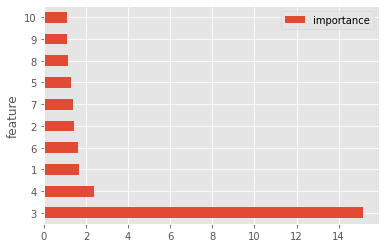

In [45]:
import math
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, abs(w))
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

##### Even with cross validation the results are too perfect. Then let's use only one type of AuNPs

## b) Use only COOH spectra

In [46]:
kind='COOH'

### Divide to Train, Validation, (Train+Validation) and Test populations

In [47]:
X_HF, Y_HF = transform_to_XY(data_1celltype = data_filt['HF'], ylabel = 0, aunp_kind=kind)
print('HF dataset, X:', X_HF.shape)

X_ZAM, Y_ZAM = transform_to_XY(data_1celltype = data_filt['ZAM'], ylabel = 1, aunp_kind=kind)
print('ZAM train set:', Y_ZAM.shape)

X = np.concatenate([X_HF, X_ZAM], axis=0)
Y = np.concatenate([Y_HF, Y_ZAM], axis=0)
print('Overall X:', X.shape)
print('Overall Y:', Y.shape)

n_samples:  50
HF dataset, X: (50, 2090)
n_samples:  50
ZAM train set: (50,)
Overall X: (100, 2090)
Overall Y: (100,)


In [48]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=42)
print('X_train_val: ',X_train_val.shape)
print('X_test: ',X_test.shape)

X_train_val:  (80, 2090)
X_test:  (20, 2090)


## PCA 
#### (repeat the same but with another set of data (one third of what was earlier)

In [49]:
#Will norm spectra by area
area_norm = X_train_val.sum(axis=1)
spectra_normed_trainval = np.array(X_train_val)/area_norm[:,None]
spectra_normed_trainval.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [50]:
#Now scale every feature separately
pre_pca_scaler = preprocessing.StandardScaler()
X_scaled = pre_pca_scaler.fit_transform(spectra_normed_trainval) 


In [51]:
# for using far below, let's process test data in the same way
area_norm = X_test.sum(axis=1)
spectra_normed_test = np.array(X_test)/area_norm[:,None] #Normalized each spectrum by its own weight
Xtest_scaled = pre_pca_scaler.transform(spectra_normed_test) #Then standardized each feature (as previously set)


#### PCA implementation

In [54]:
pca = PCA(n_components=10, random_state=42)

principalComponents_trainval = pca.fit_transform(X_scaled)
principalComponents_test = pca.transform(Xtest_scaled)

principalDataframe_trainval = pd.DataFrame(data = principalComponents_trainval, columns = np.arange(1, 11))

In [55]:
Y_train_val_cat = pd.DataFrame(data=np.round(Y_train_val,0), columns=['class']).astype('category')
principalDataframe_trainval_y = pd.concat([principalDataframe_trainval, Y_train_val_cat], axis=1)
principalDataframe_trainval_y

1          2          3          4          5          6  \
0   -1.783741  29.128259  15.896470   1.039759  16.095287 -14.037197   
1   -4.554628 -15.452755  -3.321127  -6.299045   5.530699   8.565691   
2   39.582599 -11.067373  13.819556   9.195552 -15.786942  10.616467   
3   -4.334886  -5.778505  11.756458   5.717992 -11.279602   3.283704   
4  -15.842509 -17.092858  -2.237943  13.101712 -13.920407  -5.253103   
..        ...        ...        ...        ...        ...        ...   
75  21.706629  16.434385 -13.979880  14.898477  -4.940597   1.775240   
76  16.531287  10.247355 -14.308440   7.268175  -1.954235   0.750448   
77  41.832534 -10.881889  10.044870  -1.131664   0.209858 -13.642110   
78 -12.776075  19.987246  -7.092998  -5.751700  -6.947892   0.318722   
79  36.973827   0.084257 -14.020024  -0.379353   6.940655  -1.045760   

            7          8          9         10 class  
0   17.698373  -5.949755  -1.712327  -6.460103   0.0  
1    4.220264  -1.051483   0.064198  -7.877445   1.0  
2   -1.199134  -7.801327 -16.475334   4.803494   1.0  
3    9.464797   2.324840  -3.453779  -7.918571   1.0  
4   -1.333493 -17.847231  12.087262  -8.113440   1.0  
..        ...        ...        ...        ...   ...  
75   1.005528  14.685944   2.713783  -7.985154   0.0  
76  -1.741952   1.754327   0.902123   1.346304   0.0  
77 -20.269768   2.303894   4.646693  -5.338944   1.0  
78  -3.309068   1.680713  -6.214051  -0.546441   0.0  
79   1.042543  -1.924665  -1.654405  17.279624   0.0  

[80 rows x 11 columns]

In [56]:
import plotly.express as px

fig = px.scatter(principalDataframe_trainval_y, x=1, y=2, color = 'class')
fig.update_traces(marker_size=10)
fig.update_layout(xaxis_title='PC1', yaxis_title='PC2' )
fig.show()

In [57]:
fig = px.scatter( principalDataframe_trainval_y, x=2, y=3, color = 'class')
fig.update_traces(marker_size=10)
fig.update_layout(xaxis_title='PC2', yaxis_title='PC3')
fig.show()

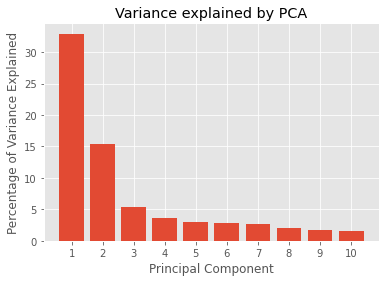

In [58]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = np.arange(1,11)
plt.bar(x= columns, height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Variance explained by PCA')
plt.show()

Text(0.5, 1.0, 'PCA Correlation matrix')

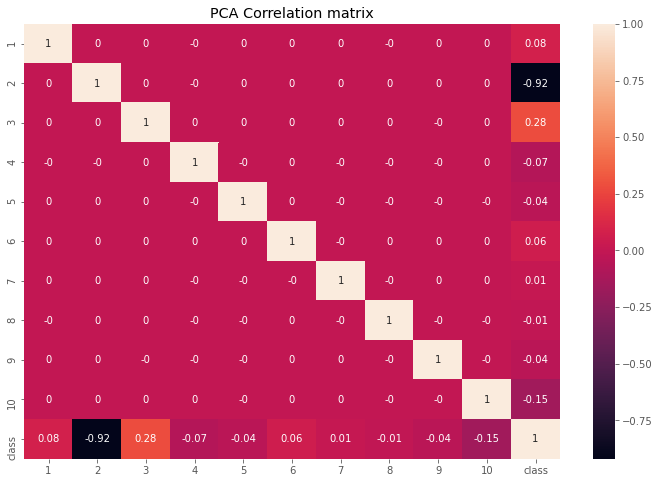

In [59]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(np.round(principalDataframe_trainval_y.corr(numeric_only=False),2), annot=True)
plt.title('PCA Correlation matrix')

##### Now PC2 is correlated with class label.
##### Meanwhile, PCs are not correlated with each other, that is natural due to their indepencence

### Logistic Regression

In [60]:
X_trainval_PCA = principalDataframe_trainval
scaler = preprocessing.StandardScaler()
X_trainval_PCA_scaled = scaler.fit_transform(X_trainval_PCA) 

Xtest_scaled = scaler.transform(principalComponents_test)


In [61]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='sag')
logreg.fit(X_trainval_PCA_scaled, Y_train_val)

LogisticRegression(solver='sag')

In [62]:
Y_trainval_predict = logreg.predict(X_trainval_PCA_scaled)

print(classification_report(Y_train_val, Y_trainval_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [63]:
Y_test_predict = logreg.predict(Xtest_scaled)

print(classification_report(Y_test, Y_test_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### ROC AUC

ROC AUC на тестовом наборе: 1.00


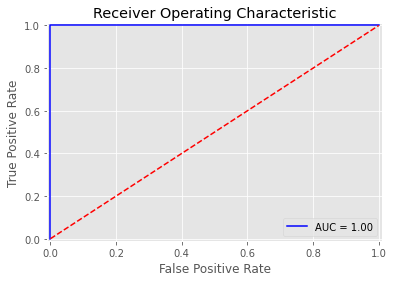

In [64]:
Y_test_pred_proba = logreg.predict_proba(Xtest_scaled)
print('ROC AUC на тестовом наборе: {:.2f}'.format(roc_auc_score(Y_test, Y_test_pred_proba[:,1])))

preds = Y_test_pred_proba[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Cross Validation

In [65]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = linear_model.LogisticRegression(solver='sag')

train_recall = []
val_recall = []
train_rocauc = []
val_rocauc = []
    
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, val_index in kf.split(X_train_val, Y_train_val): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, Y_train = X[train_index,:], Y[train_index]
    X_val, Y_val = X[val_index,:], Y[val_index]
    
    #Processing before PCA for train
    ##Normalize each spectrum
    area_norm = X_train.sum(axis=1)
    spectra_normed_train = np.array(X_train)/area_norm[:,None]
    ##Standardize each feature
    pre_pca_scaler = preprocessing.StandardScaler()
    X_scaled_train = pre_pca_scaler.fit_transform(spectra_normed_train)
    
    #Performing PCA on train
    pca = PCA(n_components=10, random_state=42)
    principalComponents_train = pca.fit_transform(X_scaled_train)
    #principalDataframe_train = pd.DataFrame(data = principalComponents_train, columns = np.arange(1, 11))
    #Y_train_cat = pd.DataFrame(data=np.round(Y_train,0), columns=['class']).astype('category')
    #principalDataframe_y = pd.concat([principalDataframe_train, Y_train_cat], axis=1)
    
    #After PCA, preparing train to ML
    scaler = preprocessing.StandardScaler()
    X_train_PCA_scaled = scaler.fit_transform(principalComponents_train) 
    
    #Processing before PCA for val
    area_norm = X_val.sum(axis=1)
    spectra_normed_val = np.array(X_val)/area_norm[:,None] #Normalized each spectrum by its own weight
    X_val_scaled = pre_pca_scaler.transform(spectra_normed_val) #Then standardized each feature (as previously set)

    #Performing PCA on val
    principalComponents_val = pca.transform(X_val_scaled)

    #After PCA, preparing val to ML
    X_val_PCA_scaled = scaler.transform(principalComponents_val)

    #ML
    logreg.fit(X_train_PCA_scaled, Y_train)
    #Делаем предсказание для каждой из выборок
    Y_train_pred = logreg.predict(X_train_PCA_scaled)
    Y_val_pred = logreg.predict(X_val_PCA_scaled)
    Y_train_pred_proba = logreg.predict_proba(X_train_PCA_scaled)
    Y_val_pred_proba = logreg.predict_proba(X_val_PCA_scaled)
    #Рассчитываем метрику и заносим её в список
    train_recall.append(recall_score(Y_train, Y_train_pred))
    val_recall.append(recall_score(Y_val, Y_val_pred))
    train_rocauc.append(roc_auc_score(Y_train, Y_train_pred_proba[:,1]))
    val_rocauc.append(roc_auc_score(Y_val, Y_val_pred_proba[:,1]))                        

print('Train k-fold mean recall: {:.2f}'.format(np.mean(train_recall)))
print('Valid k-fold mean recall: {:.2f}'.format(np.mean(val_recall)))

Train k-fold mean recall: 1.00
Valid k-fold mean recall: 1.00


In [66]:
print('Train k-fold mean rocauc: {:.2f}'.format(np.mean(train_rocauc)))
print('Valid k-fold mean rocauc: {:.2f}'.format(np.mean(val_rocauc)))

Train k-fold mean rocauc: 1.00
Valid k-fold mean rocauc: 1.00


### Feature importances
https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/

In [67]:
# Built model stores intercept and coefficients already. Let’s focus on those parameters to understand the algorithm well.
w0 = logreg.intercept_[0]
w = w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) + (%f * x4) + (%f * x5) + (%f * x6) + (%f * x7) + (%f * x8) + (%f * x9) + (%f * x10)" % (w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10)
print(equation)


y = -1.042686 + (0.494203 * x1) + (-2.698247 * x2) + (0.932357 * x3) + (0.331829 * x4) + (0.198268 * x5) + (0.081746 * x6) + (0.254726 * x7) + (-0.395010 * x8) + (-0.256638 * x9) + (0.245400 * x10)


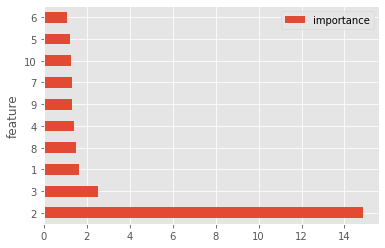

In [69]:
import math
feature_names = X_trainval_PCA.columns
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, abs(w))
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

### Conclusion: 
#### Even with  one type of AuNPs and cross validation the results are too perfect, although there wasn't any data leak.
#### For further research, it could be interesting to test more data, as now our overall dataset is limited to 100 samples.